In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch import optim
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer

In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def train_one_epoch(model: nn.Module, train_loader: DataLoader, optimizer: optim):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = nn.NLLLoss()

    for batch in (pbar := tqdm(train_loader, leave = False)):
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        accuracy = 100 * correct / total
        pbar.set_description(f'Train Accuracy = {accuracy:.2f}% | Loss = {loss.item():.3f}')

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = 100 * correct / total
    return avg_loss, avg_accuracy

In [5]:
def evaluate(model: nn.Module, test_loader: DataLoader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = 0
    loss_fn = nn.NLLLoss()

    with torch.no_grad():

        for batch in (pbar := tqdm(test_loader, leave=False)):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
            pbar.set_description(f'Test Accuracy = {accuracy:.2f}% | Loss = {loss.item():.3f}')

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = 100 * correct / total
    return avg_loss, avg_accuracy

In [32]:
def test(model: nn.Module, test_loader: DataLoader, classes: dict):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm_display_labels = [classes[i] for i in range(len(classes))]

    plt.figure(figsize = (10, 7))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = cm_display_labels, yticklabels = cm_display_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
def train(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, n_epochs: int = 1, learning_rate: float = 1e-4):
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        pbar.set_description(f'Train Accuracy = {train_acc:.2f}% | Loss = {train_loss:.3f}')
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        test_loss, test_acc = evaluate(model, test_loader)
        pbar.set_description(f'Test Accuracy = {test_acc:.2f}% | Loss = {test_loss:.3f}')
        history['val_loss'].append(test_loss), history['val_acc'].append(test_acc)

    plot_training_curves(history)

    return history

In [27]:
def plot_training_curves(results):
    epochs_range = range(1, len(results['train_loss']) + 1)
    plt.figure(figsize = (14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, results['train_loss'], label = 'Train Loss')
    plt.plot(epochs_range, results['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.xticks(epochs_range)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, results['train_acc'], label = 'Train Accuracy')
    plt.plot(epochs_range, results['val_acc'], label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.xticks(epochs_range)
    plt.yticks(range(0, 101, 10))
    plt.legend()

    plt.tight_layout()
    plt.show()

In [38]:
def display_predictions(model: nn.Module, test_loader: DataLoader, tokenizer, classes: dict, num_samples: int = 10):
    model.eval()
    samples_shown = 0
    max_seq_len = test_loader.dataset[0]['input_ids'].shape[0]

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(inputs)

            for i in range(len(inputs)):
                if samples_shown >= num_samples:
                    return

                input_text = tokenizer.decode(inputs[i], skip_special_tokens = True)
                probs = nn.functional.softmax(outputs[i], dim=0)

                true_labels = classes[labels[i].item()]
                pred_probs = {classes[j]: probs[j].item() for j in range(len(classes))}

                print(f'Sample {samples_shown + 1}')
                print(f'Text: {input_text}')
                print(f'True Label: {true_labels}')
                print(f'Predicted Probabilities:\n{pd.Series(pred_probs).to_string()}')
                print('=' * 80)

                samples_shown += 1

In [10]:
ag_dataset = load_dataset('ag_news')
train_dataset = ag_dataset['train']
test_dataset = ag_dataset['test']
classes = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
num_classes = len(classes)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [11]:
text = train_dataset['text'][40*477]
label = train_dataset['label'][40*477]
print(classes[label], ':', text[:477])

World : Clinton Surgery Expected Early This Week Former President Bill Clinton's heart bypass, expected Monday or Tuesday, likely will be an ordinary replumbing of his ailing heart, not some new whiz-bang robotic or "keyhole" surgery, leading surgeons say.    And just as his operation is likely to be the same as the average American's, the delay in his surgery also suggests a problem typical for many patients: doctors and nurses off for the holiday weekend...


In [12]:
text = train_dataset['text'][2024]
label = train_dataset['label'][2024]
print(classes[label], ':', text[:477])

Sports : Phelps #39;s dreams meet not-so-bad realities ATHENS Imagine, just for the length of a breezy, sun-kissed summer evening in Athens, that you had not heard a word about Michael Phelps before these Olympics began. That you knew nothing about his childhood in Baltimore; the failed Olympic dreams of his ...


In [13]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_len = 48
vocab_size = tokenizer.vocab_size

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
def preprocess(texts, labels, max_length = max_len):
    inputs = tokenizer(texts, padding = 'max_length', truncation = True, max_length = max_length, return_tensors = 'pt')
    inputs['labels'] = torch.tensor(labels)
    return inputs

In [15]:
train_inputs = preprocess(train_dataset['text'], train_dataset['label'])
test_inputs = preprocess(test_dataset['text'], test_dataset['label'])

In [16]:
class AGNewsDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        return item

In [17]:
train_dataset = AGNewsDataset(train_inputs)
test_dataset = AGNewsDataset(test_inputs)

In [18]:
batch_size = 64

In [19]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [20]:
len(train_dataset), len(test_dataset)

(120000, 7600)

In [21]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout: float):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def calculate_score(self, queries: Tensor, keys: Tensor) -> Tensor:
        return torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(queries.shape[-1])

    def forward(self, queries: Tensor, keys: Tensor, values: Tensor, batch_size: int, num_heads: int, seq_length: int, dim_k: int) -> Tensor:
        keys = keys.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)
        queries = queries.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)
        values = values.transpose(1, 2).contiguous().view(batch_size * num_heads, seq_length, dim_k)

        score = self.calculate_score(queries, keys)
        softmax_weights = F.softmax(score, dim=2)

        out = torch.bmm(self.dropout(softmax_weights), values)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, num_heads * dim_k)

        return out

In [22]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int = 8, dropout: float = 0.1):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.to_keys = nn.Linear(embed_dim, embed_dim * num_heads, bias = False)
        self.to_queries = nn.Linear(embed_dim, embed_dim * num_heads, bias = False)
        self.to_values = nn.Linear(embed_dim, embed_dim * num_heads, bias = False)
        self.unify_heads = nn.Linear(embed_dim * num_heads, embed_dim)

        self.attention = DotProductAttention(dropout)

    def forward(self, x: Tensor) -> Tensor:
        batch_size, seq_length, embed_dim = x.size()
        num_heads = self.num_heads

        queries = self.to_queries(x).view(batch_size, seq_length, num_heads, embed_dim)
        keys = self.to_keys(x).view(batch_size, seq_length, num_heads, embed_dim)
        values = self.to_values(x).view(batch_size, seq_length, num_heads, embed_dim)

        out = self.attention(queries, keys, values, batch_size, num_heads, seq_length, embed_dim)

        return self.unify_heads(out)

In [23]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_dim, num_heads = num_heads)

        self.norm_1 = nn.LayerNorm(embed_dim)
        self.norm_2 = nn.LayerNorm(embed_dim)

        hidden_size = 2 * embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, embed_dim)
        )

    def forward(self, x: Tensor) -> Tensor:
        attended = self.attention(x)
        x = self.norm_1(attended + x)

        feedforward = self.mlp(x)
        x = self.norm_2(feedforward + x)

        return x

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout = 0.1, max_len = 512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)

        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-np.log(10000.0) / emb_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [25]:
class Transformer(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, depth: int, seq_length: int, num_tokens: int, num_classes: int):
        super(Transformer, self).__init__()

        self.embed_dim = embed_dim
        self.num_tokens = num_tokens
        self.token_embedding = nn.Embedding(num_tokens, embed_dim)
        self.pos_enc = PositionalEncoding(embed_dim)

        transformer_blocks = [TransformerBlock(embed_dim = embed_dim, num_heads = num_heads) for _ in range(depth)]
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.classification_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        x = self.token_embedding(x) * np.sqrt(self.embed_dim)
        x = self.pos_enc(x)
        x = self.transformer_blocks(x)

        sequence_avg = x.mean(dim=1)
        x = self.classification_head(sequence_avg)
        logprobs = F.log_softmax(x, dim=1)
        return logprobs

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

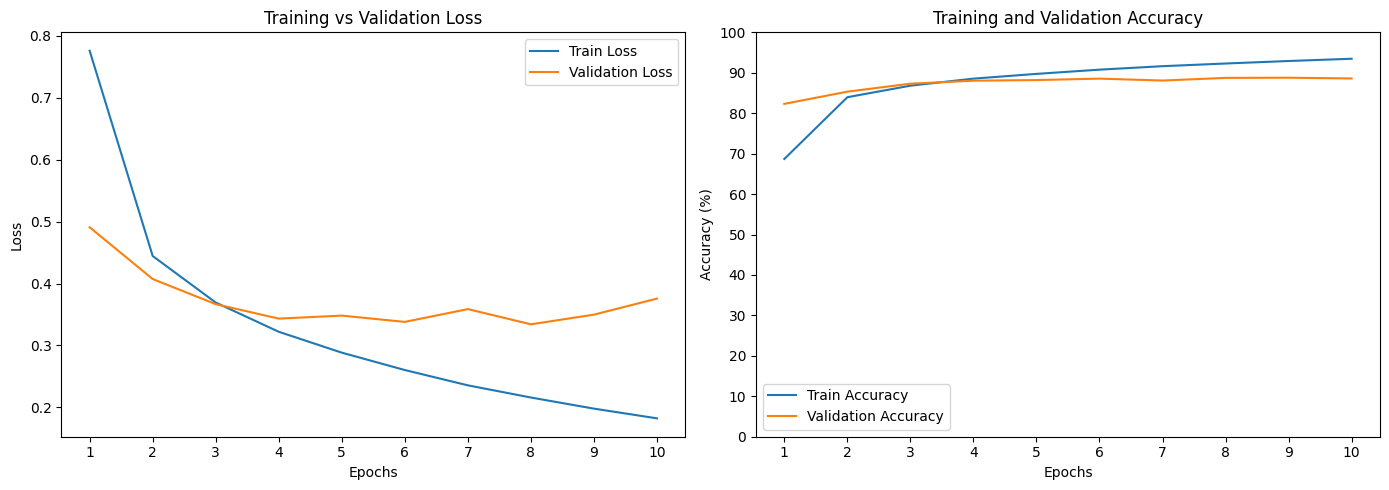

In [28]:
model = Transformer(128, 8, 3, max_len, vocab_size, num_classes).to(device)
results = train(model, train_loader = train_loader, test_loader = test_loader, n_epochs = 10)

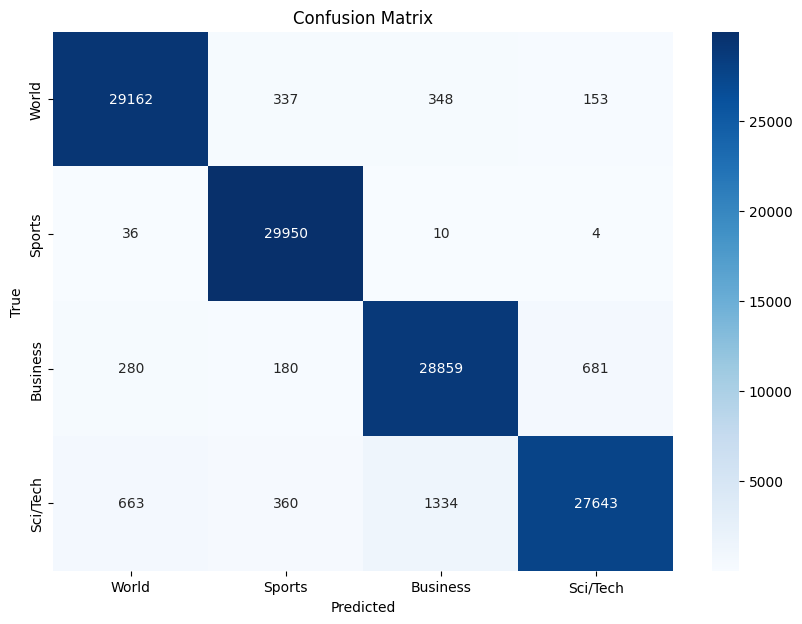

In [33]:
test(model, train_loader, classes)

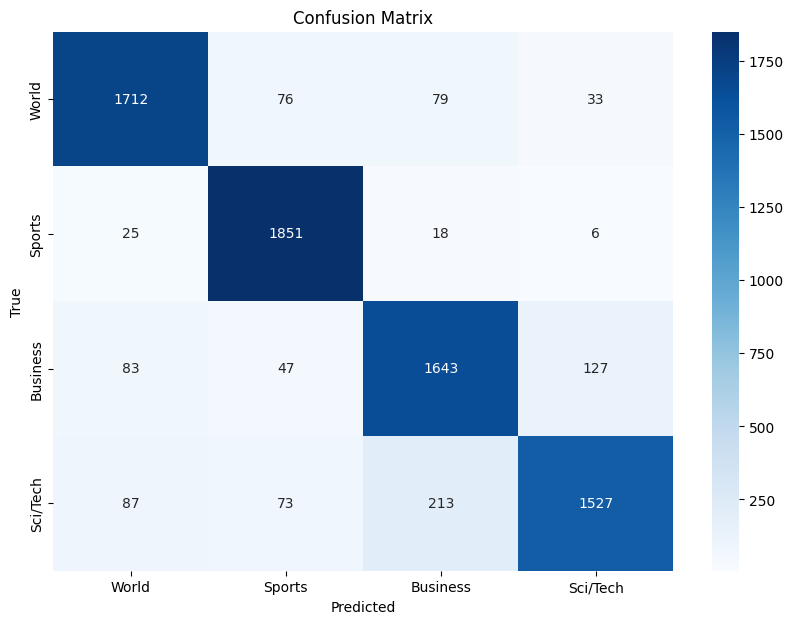

In [34]:
test(model, test_loader, classes)

In [39]:
display_predictions(model, test_loader, tokenizer, classes)

Sample 1
Text: fears for t n pension after talks unions representing workers at turner newall say they are ' disappointed ' after talks with stricken parent firm federal mogul.
True Label: Business
Predicted Probabilities:
World       0.040419
Sports      0.000010
Business    0.957273
Sci/Tech    0.002298
Sample 2
Text: the race is on : second private team sets launch date for human spaceflight ( space. com ) space. com - toronto, canada - - a second \ team of rocketeers competing for the # 36 ; 10 million ansari
True Label: Sci/Tech
Predicted Probabilities:
World       0.000065
Sports      0.015299
Business    0.000431
Sci/Tech    0.984206
Sample 3
Text: ky. company wins grant to study peptides ( ap ) ap - a company founded by a chemistry researcher at the university of louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids
True Label: Sci/Tech
Predicted Probabilities:
World       0.013915
Sports      0.000955
Business    0.00097

# Resources
Attention Is All You Need

BERT: Pre-trained of Deep Bidirectional Transformers for Language Understanding

Attention and Transformers from Neuromatch Academy.